In [1]:
import atmPy
from atmPy.aerosols.physics import hygroscopicity as hyg
from atmPy.data_archives import arm
from atmPy.aerosols.size_distribution import sizedistribution
%matplotlib inline
plt.style.use('hagen_default')

# HygroscopicGrowthFactorDistributions

We need to generate a data set that can be used to initiate a HygroscopicGrowthFactorDistributions instance. Hiere we take Arm data generated by a HTDMA. The Arm data contains gf-distributions for different diameters, so we select one (200.0 nm).

In [23]:
fname = '../atmPy/unit_testing/test_data/sgptdmahygC1.b1.20120601.004227.cdf'
fname = '/Users/htelg/data/ARM/SGP/tdmahyg/sgptdmahygC1.b1.20120115.001536.cdf'
out = arm.read_netCDF(fname, data_quality= 'patchy', leave_cdf_open= False)

## in general

Peaks in the gf-distribution are detected and fit by normal distributions (at log-base). Fit parameters are tightly constrained to avoid run-away parameters and unrealistic results, which in turn can result in unexpacted results ... hard coded fit parameters/boundaries might need adjustment.

## Growth modes

Position of detected growthmodes and ratio of particles in it as a function of time. Here plotted on top of the gf-distribution time series.

(<matplotlib.figure.Figure at 0x11f641438>,
 None)

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


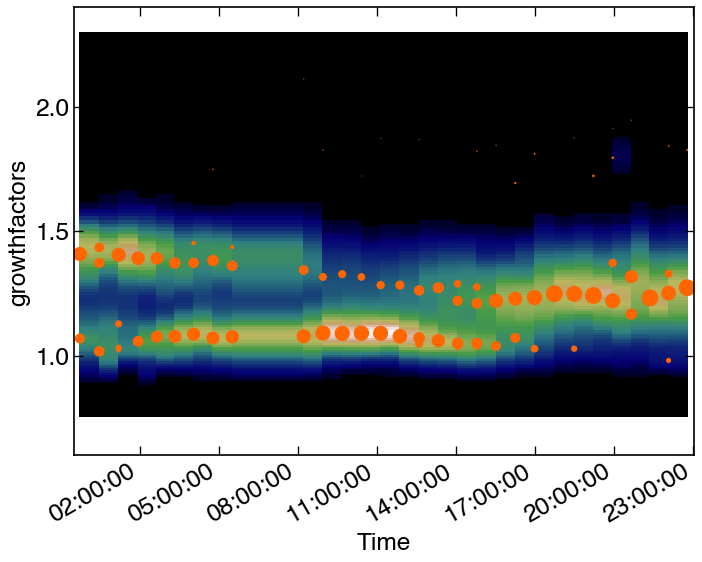

In [59]:
fname = '/Users/htelg/data/ARM/SGP/tdmahyg/sgptdmahygC1.b1.20120228.002857.cdf'
out = arm.read_netCDF(fname, data_quality= 'patchy', leave_cdf_open= False)

# %%debug --breakpoint /Users/htelg/prog/atm-py/atmPy/aerosols/physics/hygroscopicity.py:523
out.hyg_distributions_d200nm.plot(growth_modes=True)

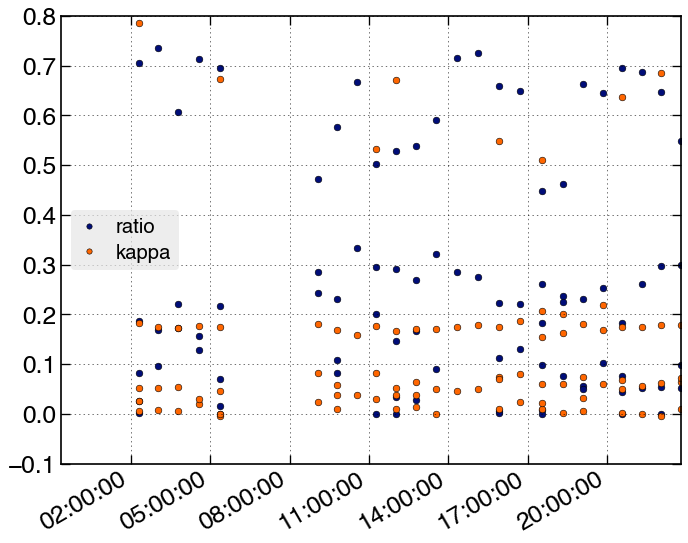

In [29]:
out.hyg_distributions_d200nm.growth_modes_kappa.plot(ls = '', marker = 'o')

## Mixing state

I came up with the following definition, it should be adjusted if there is a better one in the literature
 
Mixing state is given by the pythagoras of the particle ratios of all detected growth modes in a growth distribution. E.g. if there where three modes detected with ratios $r_1$, $r_2$, $r_3$ the mixing state is given by $\sqrt{r_1^2 + r_2^2 + r_3^2}$.

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/axes/_base.py:2305: RuntimeWarning: invalid value encountered in double_scalars
  delta = (x1t - x0t) * margin


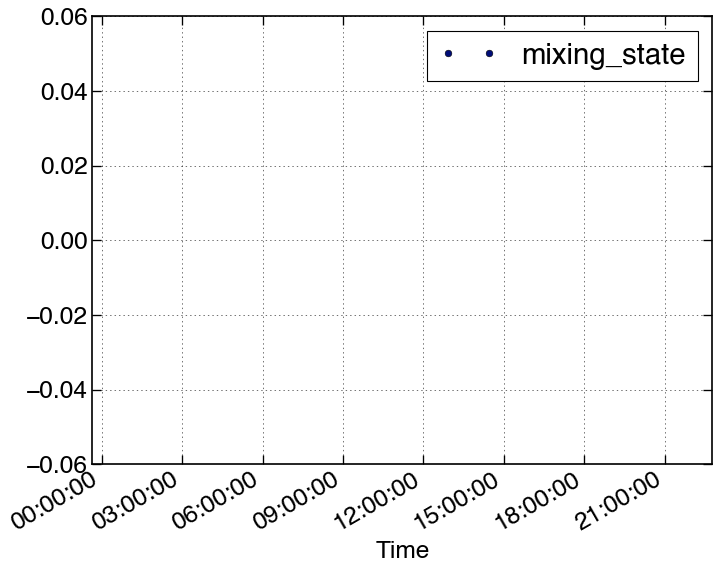

In [15]:
out.hyg_distributions_d200nm.mixing_state.plot(marker = 'o', ls = '')

## Grown size distribution

this is the sum. for optical properties the individual information is used so the change in the refractive index which is different for each growth mode is considered individually.

In [3]:
# fname = '../atmPy/unit_testing/test_data/sgptdmaapssizeC1.c1.20120601.004227.cdf'
fname = '/Users/htelg/data/ARM/SGP/tdmaaps/sgptdmaapssizeC1.c1.20111121.002408.cdf'
tdmaaps = arm.read_netCDF(fname, data_quality= 'patchy', leave_cdf_open= False)
sd = tdmaaps.size_distribution

In [4]:
hgfd = out.hyg_distributions_d200nm
# gmk = out.hyg_distributions_d200nm.growth_modes_kappa

(<matplotlib.figure.Figure at 0x107346cc0>,
 <matplotlib.colorbar.Colorbar at 0x107d6c860>)

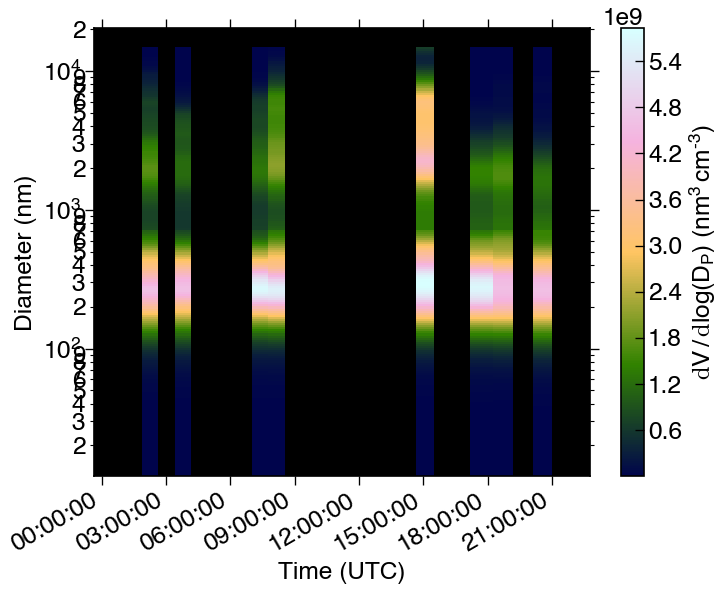

In [18]:
sd.convert2dVdlogDp().plot()

In [5]:
sd.hygroscopicity.parameters.growth_distribution = hgfd
sd.hygroscopicity.parameters.RH = 90

In [21]:
hgfd

growthfactors        0.75351  0.76058  0.76772  0.77492  0.78219  0.78953  \
Time                                                                        
2011-11-20 23:39:08      NaN      NaN      NaN      NaN      NaN      NaN   
2011-11-21 00:22:54      NaN      NaN      NaN      NaN      NaN      NaN   
2011-11-21 01:08:10      NaN      NaN      NaN      NaN      NaN      NaN   
2011-11-21 01:54:54      NaN      NaN      NaN      NaN      NaN      NaN   
2011-11-21 02:40:08      NaN      NaN      NaN      NaN      NaN      NaN   
2011-11-21 03:25:24      NaN      NaN      NaN      NaN      NaN      NaN   
2011-11-21 04:12:08      NaN      NaN      NaN      NaN      NaN      NaN   
2011-11-21 07:01:35      NaN      NaN      NaN      NaN      NaN      NaN   
2011-11-21 07:45:34      NaN      NaN      NaN      NaN      NaN      NaN   
2011-11-21 08:35:02      NaN      NaN      NaN      NaN      NaN      NaN   
2011-11-21 09:25:55      NaN      NaN      NaN      NaN      NaN      NaN   

(<matplotlib.figure.Figure at 0x1157619e8>,
 <matplotlib.colorbar.Colorbar at 0x116b06390>)

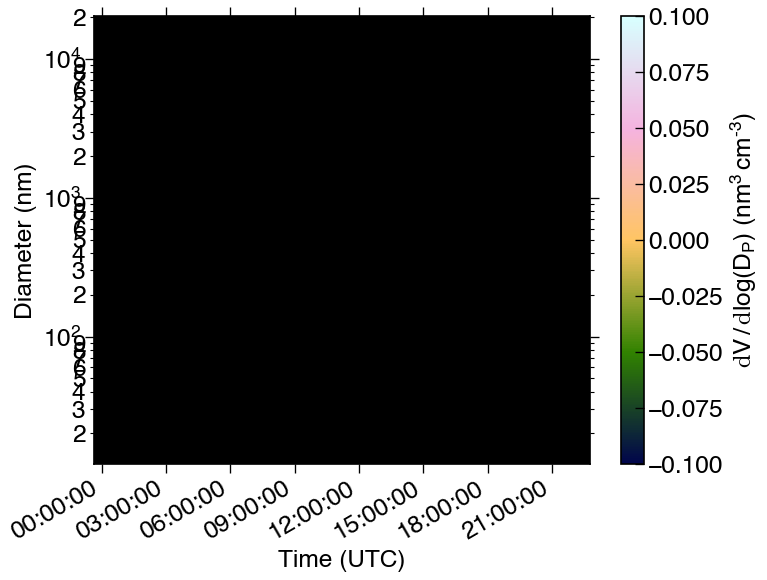

In [6]:
# %%debug --breakpoint /Users/htelg/prog/atm-py/atmPy/aerosols/size_distribution/sizedistribution.py:403
# %%debug --breakpoint /Users/htelg/prog/atm-py/atmPy/aerosols/physics/hygroscopicity.py:894
sd.hygroscopicity.grown_size_distribution.sum_of_all_sizeditributions.convert2dVdlogDp().plot()

## Optical properties

### scattering

In [ ]:
2011-01-10 17:51:46

In [ ]:
i == _pd.Timestamp('2011-01-10 17:51:46')
pd.DatetimeIndex([pd.Timestamp('2011-01-10 17:51:46')])

pd.Timestamp('2011-01-10 17:51:46')

In [7]:
sd.optical_properties.parameters.wavelength = 550
sd.optical_properties.parameters.refractive_index = 1.5
# sd.hygroscopicity.parameters.RH = 85.

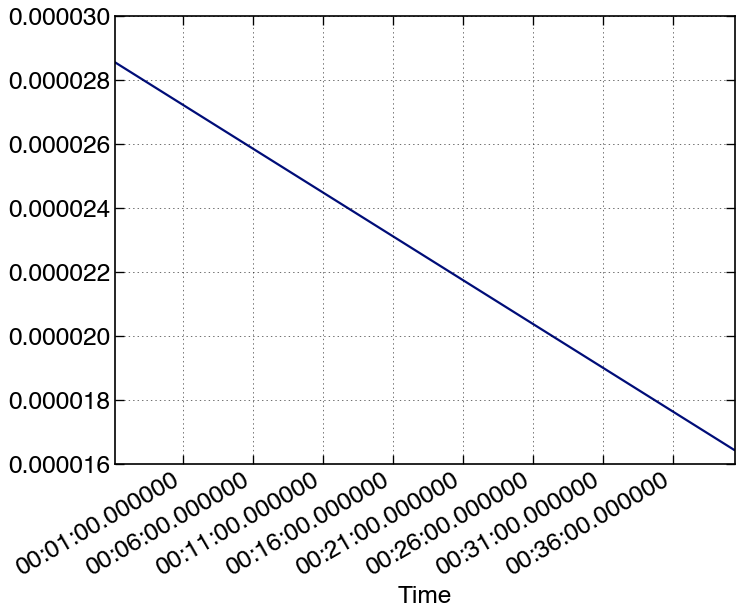

In [8]:
# %%debug --breakpoint /Users/htelg/prog/atm-py/atmPy/aerosols/physics/optical_properties.py:92
sd.hygroscopicity.grown_size_distribution.optical_properties.scattering_coeff.plot()

In [ ]:
sd.hygroscopicity.grown_size_distribution.optical_properties.scattering_coeff.data

### fRH

/Users/htelg/prog/atm-py/atmPy/aerosols/physics/optical_properties.py:112: RuntimeWarning: invalid value encountered in true_divide
  y_phase_func = y_1p * 4 * _np.pi / scattering_cross_eff.sum()


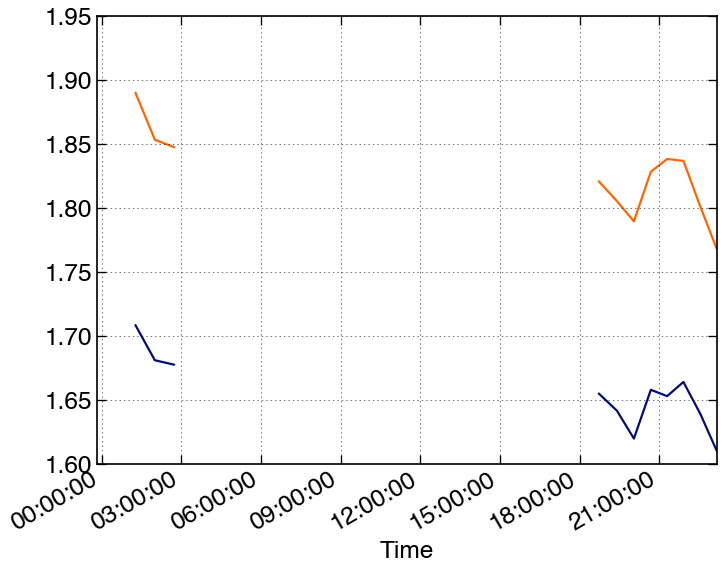

In [18]:
a = sd.hygroscopicity.f_RH_85_40.plot()
sd.hygroscopicity.f_RH_85_0.plot(ax = a)

In [19]:
a = sd.hygroscopicity.f_RH

/Users/htelg/prog/atm-py/atmPy/aerosols/physics/optical_properties.py:112: RuntimeWarning: invalid value encountered in true_divide
  y_phase_func = y_1p * 4 * _np.pi / scattering_cross_eff.sum()


## Development

### catch fit runaways

In [11]:
from atmPy.tools import math_functions as _math_functions
def multi_gauss(x, *params, verbose=False):
    #     print(params)
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        if verbose:
            print(len(params), i)
        amp = params[i]
        pos = params[i + 1]
        sig = params[i + 2]
        y = y + _math_functions.gauss(x, amp, pos, sig)
    return y

In [ ]:
# %%debug --breakpoint /Users/htelg/prog/atm-py/atmPy/aerosols/physics/hygroscopicity.py:523
out.hyg_distributions_d200nm.plot(growth_modes=True)

atmPy.aerosols.physics.hygroscopicity
ipdb> globals()['x'] = x
ipdb> globals()['y'] = y
ipdb> globals()['param'] = param
ipdb> globals()['bound_l'] = bound_l
ipdb> globals()['bound_h'] = bound_h
globals()['x'] = x; globals()['y'] = y; globals()['param'] = param; globals()['bound_l'] = bound_l; globals()['bound_h'] = bound_h

In [7]:
x = atmPy.aerosols.physics.hygroscopicity.x
y = atmPy.aerosols.physics.hygroscopicity.y
param = atmPy.aerosols.physics.hygroscopicity.param
bound_l = atmPy.aerosols.physics.hygroscopicity.bound_l
bound_h= atmPy.aerosols.physics.hygroscopicity.bound_h

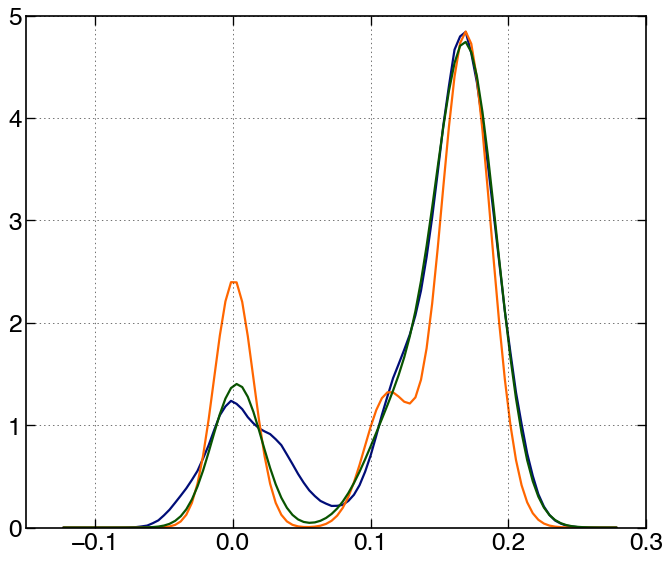

In [36]:
plt.plot(x,y)
plt.plot(x, y_start)
plt.plot(x, new_y)

In [ ]:
parry = np.array(param)
# parry[::3] *= 10

In [35]:
y_start = multi_gauss(x, *parry)

In [32]:
# fitres, _ = atmPy.aerosols.physics.hygroscopicity._curve_fit(multi_gauss, x, y, p0=param[:-3], bounds=(bound_l[:-3], bound_h[:-3]))
fitres, _ = atmPy.aerosols.physics.hygroscopicity._curve_fit(multi_gauss, x, y, p0=parry, bounds=(bound_l, bound_h), 
#                                                              max_nfev = 10000
                                                            )

new_y = multi_gauss(x, *fitres)

# Kappa

In [2]:
# fname = '../atmPy/unit_testing/test_data/sgptdmaapssizeC1.c1.20120601.004227.cdf
fname = '/Users/htelg/data/ARM/SGP/tdmaaps/sgptdmaapssizeC1.c1.20120201.002958.cdf'
tdmaaps = arm.read_netCDF(fname, data_quality= 'patchy', leave_cdf_open= False)

In [3]:
fname = '/Users/htelg/data/ARM/SGP/acsm/sgpaosacsmC1.b1.20120201.002022.cdf'
acsm = arm.read_netCDF(fname, data_quality= 'patchy', leave_cdf_open= False)

In [4]:
tdmaaps.size_distribution.parameters4reductions.wavelength = 550

In [5]:
# %%debug --breakpoint /Users/htelg/prog/atm-py/atmPy/aerosols/physics/hygroscopicity.py:606
tdmaaps.size_distribution.hygroscopicity.parameters.kappa = acsm.kappa
tdmaaps.size_distribution.hygroscopicity.parameters.refractive_index = acsm.refractive_index
fRH_nams_kams = tdmaaps.size_distribution.hygroscopicity.f_RH_85_0.copy()

/Users/htelg/prog/atm-py/atmPy/aerosols/instruments/AMS/AMS.py:63: UserWarning: Sulfate rich is not implemented yet. Mostly because I don't get it!
         There are not supposed to be any Nitrates or Chlorides present when we are in the sulfate rich regime ... but there are.
         I guess it has to do with the organics? Talk to chuck
  _warnings.warn(txt)
/Users/htelg/prog/atm-py/atmPy/aerosols/physics/hygroscopicity.py:52: RuntimeWarning: invalid value encountered in greater
  if _np.any(k > 1.4) or _np.any(k < 0):
/Users/htelg/prog/atm-py/atmPy/aerosols/physics/hygroscopicity.py:52: RuntimeWarning: invalid value encountered in less
  if _np.any(k > 1.4) or _np.any(k < 0):
/Users/htelg/prog/atm-py/atmPy/aerosols/physics/optical_properties.py:112: RuntimeWarning: invalid value encountered in true_divide
  y_phase_func = y_1p * 4 * _np.pi / scattering_cross_eff.sum()


In [6]:
# %%debug --breakpoint /Users/htelg/prog/atm-py/atmPy/aerosols/physics/hygroscopicity.py:742
tdmaaps.size_distribution.hygroscopicity.parameters.kappa = acsm.kappa
tdmaaps.size_distribution.hygroscopicity.parameters.refractive_index = 1.5#acsm.refractive_index
fRH_nfix_kams = tdmaaps.size_distribution.hygroscopicity.f_RH_85_0.copy()

/Users/htelg/prog/atm-py/atmPy/aerosols/physics/hygroscopicity.py:52: RuntimeWarning: invalid value encountered in greater
  if _np.any(k > 1.4) or _np.any(k < 0):
/Users/htelg/prog/atm-py/atmPy/aerosols/physics/hygroscopicity.py:52: RuntimeWarning: invalid value encountered in less
  if _np.any(k > 1.4) or _np.any(k < 0):
/Users/htelg/prog/atm-py/atmPy/aerosols/physics/optical_properties.py:112: RuntimeWarning: invalid value encountered in true_divide
  y_phase_func = y_1p * 4 * _np.pi / scattering_cross_eff.sum()


In [7]:
tdmaaps.size_distribution.hygroscopicity.parameters.kappa = acsm.kappa.data.values.mean() #acsm.kappa
tdmaaps.size_distribution.hygroscopicity.parameters.refractive_index = 1.5#acsm.refractive_index
fRH_nfix_kfix = tdmaaps.size_distribution.hygroscopicity.f_RH_85_0.copy()

/Users/htelg/prog/atm-py/atmPy/aerosols/physics/optical_properties.py:112: RuntimeWarning: invalid value encountered in true_divide
  y_phase_func = y_1p * 4 * _np.pi / scattering_cross_eff.sum()


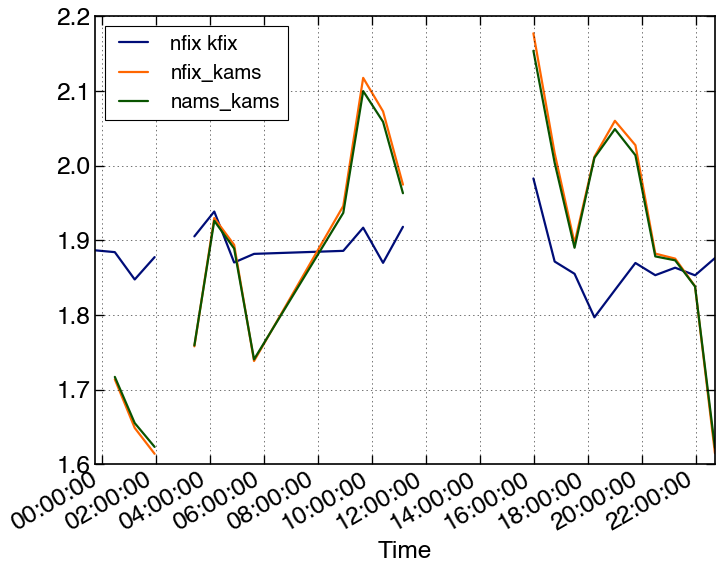

In [8]:
a = fRH_nfix_kfix.plot(label = 'nfix kfix')
fRH_nfix_kams.plot(ax = a, label = 'nfix_kams')
fRH_nams_kams.plot(ax = a, label = 'nams_kams')
a.legend()